<a href="https://colab.research.google.com/github/ELROKA02/Colab-notebooks/blob/main/Distribuci%C3%B3n_de_retornos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distribución de retornos financieros: comprendiendo la realidad del mercado

# 1. Introducción
En este cuaderno vamos a analizar cómo se comportan los retornos diarios de un activo financiero (BTC). El objetivo es comprender que los retornos no siguen una distribución normal perfecta, identificar eventos extremos y aprender a interpretar las métricas estadísticas más importantes para la inversión.

# 2. Obtencion de Datos

En este cuaderno se utilizan datos históricos de Bitcoin (BTC/USD) obtenidos a través de Kaggle, concretamente del dataset Bitcoin Historical Data. Los datos se descargan directamente en el entorno de Google Colab mediante la librería kagglehub, lo que garantiza reproducibilidad y evita dependencias externas.

El dataset original contiene precios de Bitcoin con frecuencia intradía (1 minuto), incluyendo información de apertura, máximo, mínimo, cierre y volumen. Sin embargo, para este análisis no se trabaja directamente con dicha frecuencia, ya que el objetivo del cuaderno es estudiar la distribución estadística de los retornos y no la microestructura del mercado.
Con el fin de obtener un comportamiento más estable y representativo, los datos se filtran a partir del año 2014, momento a partir del cual Bitcoin comienza a mostrar mayor liquidez y continuidad en el mercado. Posteriormente, los datos intradía se agregan a frecuencia diaria, construyendo precios diarios (Open, High, Low, Close y volumen) que serán utilizados para el cálculo de los retornos.

Esta transformación permite reducir el ruido extremo propio del intradía y centrar el análisis en el comportamiento estructural del mercado de Bitcoin a lo largo del tiempo.

In [23]:
import kagglehub
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

Using Colab cache for faster access to the 'bitcoin-historical-data' dataset.


## Vista de los datos
Antes de realizar cualquier cálculo estadístico, se presenta una vista preliminar del dataset agregado a frecuencia diaria. El objetivo de esta revisión es comprobar que las fechas son coherentes, que los precios presentan valores razonables y que el volumen agregado no muestra anomalías evidentes.
Esta inspección inicial permite validar que el proceso de filtrado temporal (a partir de 2014) y la agregación desde datos intradía se han realizado correctamente, evitando errores que podrían distorsionar el análisis posterior.

In [24]:
# Ruta
print(path)

/kaggle/input/bitcoin-historical-data


In [25]:
# Nombre del archivo
import os
os.listdir(path)

['btcusd_1-min_data.csv']

In [26]:
tabla = path+"/"+"btcusd_1-min_data.csv"

In [27]:
import pandas as pd
import numpy as np



In [28]:
df = pd.read_csv(tabla)
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


# 3. Preparación y limpieza de los datos
Los datos originales de Bitcoin se presentan con frecuencia intradía (1 minuto), por lo que es necesario realizar una preparación previa antes del análisis estadístico. En primer lugar, la columna temporal (Timestamp) se convierte a un formato de fecha legible para poder tratar los datos como una serie temporal.

El análisis se limita a datos a partir de 2014, con el objetivo de evitar periodos con baja liquidez y comportamiento poco representativo. Posteriormente, los datos se agregan a frecuencia diaria mediante la construcción de precios OHLC (Open, High, Low, Close) y el volumen total diario, reduciendo el ruido intradía.

Tras la eliminación de posibles días sin datos, se obtiene un dataset diario limpio y listo para el cálculo de retornos y el análisis estadístico.

In [29]:
# Creamos una columna Date y convertimos Timestamp a una fecha
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume,Date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [30]:
# Veamos la primera y ultima fecha
print(df['Date'].min())
print(df['Date'].max())

2012-01-01 10:01:00
2026-01-07 23:58:00


---
Como hemos dicho vamos a olvidar todos los datos antes del 2014 ya que no
habia mucha liquidez, lo que era muy inestable


In [31]:
# Cada fila la marcaremos ahora por el datetime
df = df.set_index('Date')

In [32]:
# Agrupamos de 1 minuto a diario
"""
El método resample permite cambiar la frecuencia temporal de una serie de
datos.
"""
df_daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

In [33]:
# Limitamos datos desde 2014 hasta la ultima fecha
df_daily = df_daily[df_daily.index >= '2014-01-01']

In [34]:
# cOmprobamos la fecha mas antigua y cercana
df_daily.index.min(), df_daily.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2026-01-07 00:00:00'))

# 4. Vista preliminar del dataset diario
Antes de proceder con el cálculo de retornos y el análisis estadístico, se realiza una inspección preliminar del dataset de la frecuencia diaria. El objetivo de esta revisión es comprobar que la estructura de los datos es correcta, que las columnas contienen valores coherentes y que el rango temporal coincide con el periodo de estudio seleccionado.

Mediante la visualización de las primeras y últimas filas del dataset se verifica que los datos comienzan a partir de 2014, que existe una única observación por día y que los precios y el volumen presentan valores razonables. Esta comprobación permite confirmar que el proceso de limpieza y preparación de los datos se ha realizado correctamente antes de continuar con el análisis.

In [35]:
df_daily.head()


,Open,High,Low,Close,Volume
Date,,,,,
2014-01-01,734.33,757.99,726.62,746.78,8219.685603
2014-01-02,746.78,763.80,742.50,763.23,8555.805237
2014-01-03,763.23,818.99,762.99,799.78,19859.947780
2014-01-04,797.63,830.00,790.05,822.82,11791.372032
2014-01-05,821.17,919.90,817.80,908.00,19513.308908


In [36]:
# Mostrar las últimas filas del dataset diario
df_daily.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2026-01-03,89952.0,90677.0,89289.0,90590.0,830.752131
2026-01-04,90590.0,91728.0,90590.0,91501.0,1249.276659
2026-01-05,91498.0,94792.0,91484.0,93876.0,3369.259444
2026-01-06,93876.0,94418.0,91221.0,93712.0,2746.410348
2026-01-07,93712.0,93712.0,90526.0,91304.0,2544.842890


In [37]:
# Comprobar las columnas disponibles
df_daily.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [38]:
# Comprobar el rango temporal del dataset
df_daily.index.min(), df_daily.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2026-01-07 00:00:00'))

# 5. Cálculo de retornos
Para analizar estadísticamente el comportamiento del mercado no se trabaja directamente con los precios, sino con sus variaciones relativas entre periodos consecutivos, conocidas como retornos. Esta transformación permite comparar movimientos a lo largo del tiempo y aplicar herramientas estadísticas de forma adecuada.

En este cuaderno se utilizan retornos logarítmicos, calculados a partir del precio de cierre diario. Los retornos logarítmicos presentan ventajas frente a los retornos simples, ya que convierten los cambios multiplicativos del precio en cambios aditivos, facilitan el análisis estadístico y son el enfoque estándar en estudios financieros y cuantitativos.

El cálculo de los retornos se realiza comparando el precio de cierre de cada día con el del día anterior. El primer valor no dispone de un periodo previo con el que compararse, por lo que se elimina del conjunto de datos. El resultado es una serie temporal de retornos diarios lista para su análisis estadístico y visualización.

In [39]:
# Calculamos el retorno logaritmico de cierre a cierre
df_daily['log_return'] = np.log(df_daily['Close'] / df_daily['Close'].shift(1))

#### ¿Por que se hace el log?
Imagina este caso:


*   Dia 1: BTC = 100
*   Dia 2: BTC = 110 --> +10%
*   Dia 3: BTC = 99  --> -10%

No hemos vuelto al punto inicial, por lo tanto hace que los retorno simples no sean simetricos, no se sumen bien y sean malos para estadistica.

El log convierte multiplicaciones en sumas y el mercado se mueve multiplicando, no sumando. Si hacemos el mismo ejemplo de antes:


*   Subida del 10% --> log(1.10) ≈ +0.095
*   Bajada del 10% --> log(0.90) ≈ -0.105

Y si lo sumamos:    +0.095 + (-0.105) ≈ 0

Por lo tanto, el logaritmo se usa por que el mercado se usa de forma multiplicativa y la estadistica funciona mejor de forma aditiva (sumando)



In [40]:
# Eliminamos el primer valor (el unico con NaN)
df_daily.dropna()

,Open,High,Low,Close,Volume,log_return
Date,,,,,,
2014-01-02,746.78,763.80,742.50,763.23,8555.805237,0.021789
2014-01-03,763.23,818.99,762.99,799.78,19859.947780,0.046777
2014-01-04,797.63,830.00,790.05,822.82,11791.372032,0.028401
2014-01-05,821.17,919.90,817.80,908.00,19513.308908,0.098507
2014-01-06,905.37,995.00,876.00,919.99,29034.174685,0.013118
...,...,...,...,...,...,...
2026-01-03,89952.00,90677.00,89289.00,90590.00,830.752131,0.007068
2026-01-04,90590.00,91728.00,90590.00,91501.00,1249.276659,0.010006
2026-01-05,91498.00,94792.00,91484.00,93876.00,3369.259444,0.025625


# 6. Análisis estadístico de los retornos
Una vez calculados los retornos diarios, se procede a analizar sus principales características estadísticas con el objetivo de comprender mejor el comportamiento del mercado y su nivel de riesgo. Este análisis permite ir más allá de medidas básicas como la media o la volatilidad y estudiar la forma de la distribución de los retornos.


En este apartado se analizan dos medidas que ayudan a entender cómo se comportan los retornos. La skewness indica si los movimientos más fuertes del mercado suelen darse en subidas o en caídas. Por su parte, la kurtosis muestra con qué frecuencia aparecen movimientos extremos, es decir, días con subidas o bajadas muy grandes en comparación con lo que sería un comportamiento “normal”.

> Por ejemplo, si un activo tiene muchos días con pequeñas subidas y bajadas, pero de vez en cuando sufre caídas muy grandes, diremos que tiene una skewness negativa, ya que los movimientos más extremos se concentran en las bajadas.
Si además esos días extremos aparecen con bastante frecuencia, hablaremos de una kurtosis alta, lo que indica que el activo puede experimentar movimientos bruscos más a menudo de lo que se esperaría en un mercado “normal”.

El estudio de estas métricas es especialmente relevante en mercados financieros y criptoactivos, donde los movimientos extremos ocurren con mayor frecuencia de lo que asumiría un modelo basado en una distribución normal. Este análisis proporciona una base sólida para interpretar el riesgo y entender las limitaciones de los modelos estadísticos tradicionales.

In [41]:
# Calculamos la skewness de los retornos diarios
"""
Si muestra < 0 --> Caidas extremas predominan
Si muestra > 0 --> Subidas extremas predominan
Si muestra ≈ 0 --> Comportamiento equilibrado
"""
skewness = df_daily['log_return'].skew()
skewness

np.float64(-0.2732000701898349)

In [42]:
# Calculamos la kurtosis de los retornos diarios
"""
Si muestra < 0 --> Comportamiento mas estable
si muestra > 0 --> Comportamiento mas volatil
si muestra ≈ 0 --> Comportamiento normal
"""
kutosis = df_daily['log_return'].kurtosis()
kutosis

np.float64(5.668757087419204)

El resultado que nos da el **skewness** es que Bitcoin cae fuerte menos veces, pero cuando cae, duele más (movimientos extremos se concentran en las caidas). La **kurtosis** nos dice que Bitcoin parece tranquilo… hasta que no lo es.


In [43]:
skewness, kutosis

(np.float64(-0.2732000701898349), np.float64(5.668757087419204))

# 7. Distribución de los retornos (versión simplificada)
Para comprender visualmente el comportamiento de los retornos diarios, se representa su distribución mediante un histograma. Este gráfico permite observar cómo se concentran la mayoría de los movimientos y con qué frecuencia aparecen subidas y bajadas muy grandes.

Además, la distribución de los retornos se compara con una distribución normal teórica, con el objetivo de comprobar si el comportamiento real del mercado se ajusta a lo que se consideraría un escenario “normal”. Esta comparación resulta clave para identificar si los movimientos extremos son poco frecuentes o, por el contrario, aparecen más a menudo de lo esperado.

La representación gráfica facilita la interpretación de los resultados obtenidos en el apartado anterior, mostrando de forma clara que los movimientos extremos ocurren con mayor frecuencia de la que asumiría un modelo normal. Este análisis visual refuerza la idea de que basarse únicamente en supuestos de normalidad puede llevar a subestimar el riesgo real en mercados como Bitcoin.

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import norm

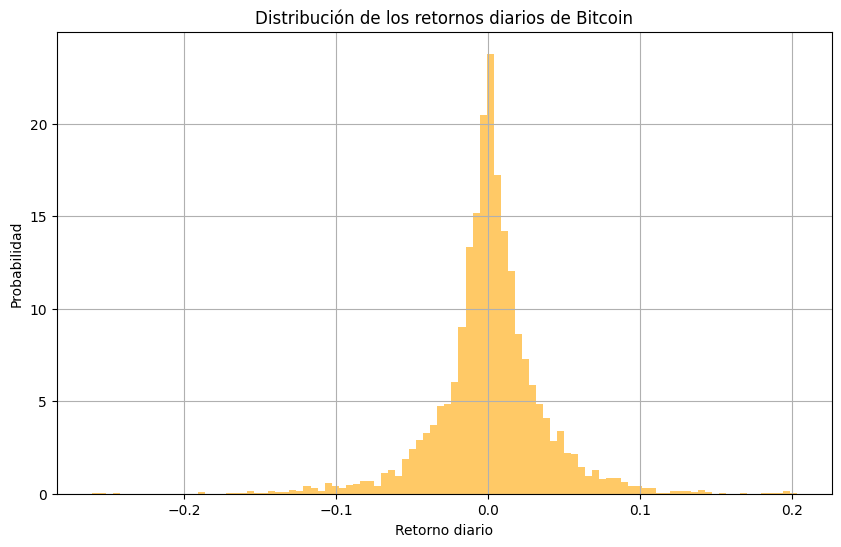

In [49]:
# Histograma de los retornos
plt.figure(figsize=(10, 6))
plt.hist(df_daily['log_return'], bins=100, density=True, alpha=0.6, color='orange')

plt.xlabel('Retorno diario')
plt.ylabel('Probabilidad')
plt.title('Distribución de los retornos diarios de Bitcoin')
plt.grid(True)

plt.show()

In [50]:
# Calculamos la media y la desviacion estandar
mu = df_daily['log_return'].mean()
sigma = df_daily['log_return'].std()

In [51]:
# Rango de valores para la normal
x = np.linspace(
    df_daily['log_return'].min(),
    df_daily['log_return'].max(),
    1000
)

In [52]:
# Calcular la normal para cada valor
y = norm.pdf(x, mu, sigma)

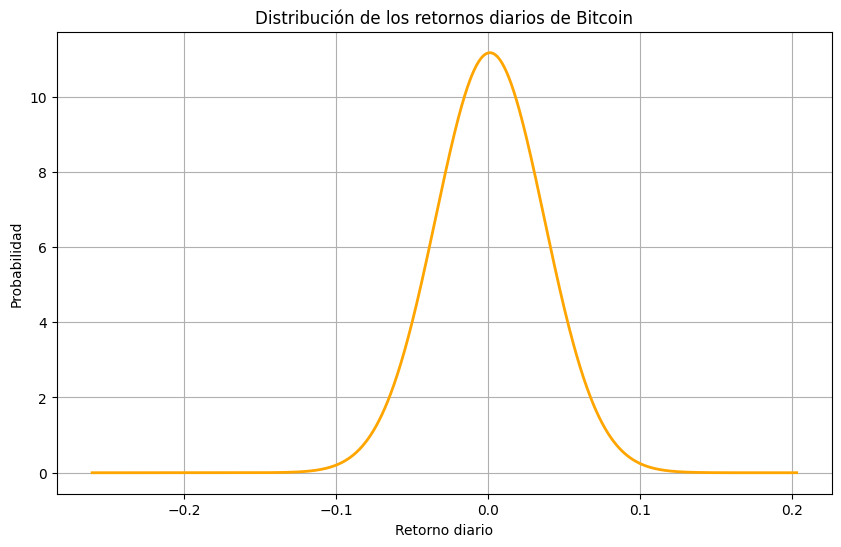

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(
    x,
    y,
    color='orange',
    linewidth=2,
)

plt.xlabel('Retorno diario')
plt.ylabel('Probabilidad')
plt.title('Distribución de los retornos diarios de Bitcoin')
plt.grid(True)

plt.show()

### Explicación de la comparación con la distribución normal
En el gráfico se puede ver que la distribución real de los retornos de Bitcoin tiene un pico más alto que la distribución normal. Esto indica que la mayoría de los días el precio de Bitcoin apenas cambia y los movimientos suelen ser pequeños.

Sin embargo, también se observa que las subidas y bajadas muy grandes aparecen más a menudo de lo que predeciría un modelo normal. Mientras que la distribución normal asume que estos movimientos extremos son muy poco frecuentes, en la realidad del mercado de Bitcoin ocurren con bastante más frecuencia.

Por este motivo, aunque muchos días parezcan tranquilos, el riesgo real es mayor de lo que sugeriría una distribución normal, ya que los movimientos bruscos siguen estando presentes.


# 8. Conclusiones

En este cuaderno hemos analizado cómo se mueve el precio de **Bitcoin** usando datos históricos y transformándolos en **retornos diarios**, que es la forma correcta de estudiar un mercado desde el punto de vista estadístico. En lugar de fijarnos solo en el precio, hemos observado **cómo cambia de un día a otro**.

El análisis muestra que **la mayoría de los días Bitcoin se mueve poco** y puede parecer un mercado tranquilo. Sin embargo, **de vez en cuando aparecen movimientos muy grandes**, tanto subidas como caídas, que ocurren **con más frecuencia de lo que se esperaría en un mercado “normal”**. Esto explica por qué, aunque muchos días no pase gran cosa, **el riesgo real sigue siendo alto**.

Al comparar los datos reales con una **distribución normal**, se ve claramente que **este modelo no representa bien la realidad de Bitcoin**. La normal asume que los movimientos extremos son muy raros, pero en Bitcoin **estos movimientos aparecen con bastante más frecuencia**. Por este motivo, **confiar solo en modelos simples puede llevar a subestimar el riesgo**.

En resumen, **Bitcoin combina muchos días tranquilos con movimientos bruscos ocasionales**, lo que lo convierte en un activo **atractivo pero también arriesgado**. **Entender este comportamiento es clave** antes de intentar hacer predicciones o tomar decisiones basadas en modelos estadísticos.
